## Deep Convolutional Neural Networks with SVHN

### A. Download and Visualize Data

**Import Libraries**

In [1]:
import os
import sys
import tarfile
import pickle
import matplotlib.pyplot as plt
import numpy as np, h5py 
import pandas as pd
from six.moves.urllib.request import urlretrieve
from IPython.display import display, Image
from PIL import Image
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
%matplotlib inline

Using TensorFlow backend.


**Create Downloader Function**

In [8]:
data_folder = 'data/'

def download_data(filename, url, expected_bytes, force=False):
    # Download a file if not present, and make sure it's the right size.
    file_path = data_folder + filename
    if force or not os.path.exists(file_path):
        filename, _ = urlretrieve(url + filename, file_path)
    statinfo = os.stat(file_path)
    if statinfo.st_size == expected_bytes:
        print('Found and verified {}'.format(filename))
    else:
        raise Exception(
          'Failed to verify {}. Can you get to it with a browser?'.format(filename))
    return file_path

def extract_data(filename, force=False):
    # Remove .tar.gz
    root = data_folder + os.path.splitext(os.path.splitext(filename)[0])[0]
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('{} already present - Skipping extraction of {}.'.format(root, filename))
    else:
        print('Extracting data for {}. This may take a while. Please wait.'.format(root))
        tar = tarfile.open(data_folder + filename)
        sys.stdout.flush()
        tar.extractall(data_folder)
        tar.close()
    return root

**Download Data**

In [9]:
url = 'http://ufldl.stanford.edu/housenumbers/'
data_folder = 'data/'

if not os.path.exists(data_folder):
    os.makedirs(data_folder)

train_filename = download_data('train.tar.gz', url, 404141560)
test_filename = download_data('test.tar.gz', url, 276555967)
extra_filename = download_data('extra.tar.gz', url, 1955489752)

train_images = extract_data('train.tar.gz')
test_images = extract_data('test.tar.gz')
extra_images = extract_data('extra.tar.gz')

Found and verified data/train.tar.gz
Found and verified data/test.tar.gz
Found and verified data/extra.tar.gz
Extracting data for data/train. This may take a while. Please wait.
Extracting data for data/test. This may take a while. Please wait.
Extracting data for data/extra. This may take a while. Please wait.


**Visualize Images from SVHN**

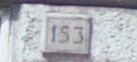

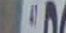

In [24]:
# Get listing of files in this directory
fn = os.listdir('data/train/')

# Loop through to load 4 images with unique names
for file in fn[2:6]:
    path = 'data/train/' + file
    display(Image(path))

**Visualize Images from SVHN: with Scale**

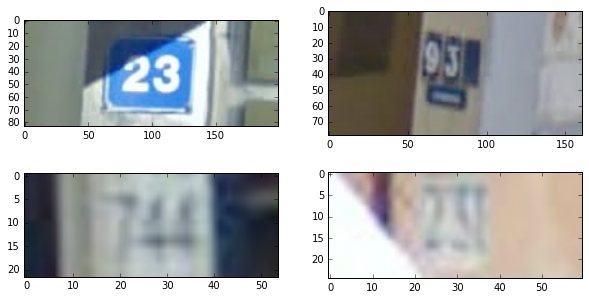

In [30]:
path = 'data/train/'
img1 = Image.open(path + '/2.png', 'r')
img2 = Image.open(path + '/4.png', 'r')
img3 = Image.open(path + '/8.png', 'r')
img4 = Image.open(path + '/16.png', 'r')

fig, ((b1, b2), (b3, b4)) = plt.subplots(2, 2, figsize=(10,5))
b1.imshow(img1)
b2.imshow(img2)
b3.imshow(img3)
b4.imshow(img4)
plt.show()

**Create Functions to Load Metadata**

In [40]:
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']


    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])


    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr


    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s
     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]


    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
               figure = {}
               figure['height'] = pictDat[i]['height'][j]
               figure['label']  = pictDat[i]['label'][j]
               figure['left']   = pictDat[i]['left'][j]
               figure['top']    = pictDat[i]['top'][j]
               figure['width']  = pictDat[i]['width'][j]
               figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

In [41]:
fin = 'data/test/digitStruct.mat'
dsf = DigitStructFile(fin)
test_data = dsf.getAllDigitStructure_ByDigit()

print('Got test data.')

fin = 'data/train/digitStruct.mat'
dsf = DigitStructFile(fin)
train_data = dsf.getAllDigitStructure_ByDigit()

print('Got train data.')

fin = 'data/extra/digitStruct.mat'
dsf = DigitStructFile(fin)
extra_data = dsf.getAllDigitStructure_ByDigit()

print('Got extra data.')

Got test data.
Got train data.
Got extra data.


### B. Preprocess Data

**Create Functions for Processing Images**

In [42]:
def labels_dict(data_set):
    l_dict = {}
    for item in data_set:
        l_dict[item['filename']] = item['boxes']        
    return l_dict

test_labels_dict = labels_dict(test_data)
train_labels_dict = labels_dict(train_data)
extra_labels_dict = labels_dict(extra_data)

In [43]:
FLAGS_image_size = 32

def process_images(folder, data_dict):
    
    process_folder = folder + '_processed'
    
    if os.path.exists(process_folder):
        print('{} folder already present - Skipping processingg images in {} folder.'.format(process_folder, folder))
    else:
        os.makedirs(process_folder)
        image_files = os.listdir(folder)
        for image in image_files:
            image_file = os.path.join(folder, image)
            try:
                img = Image.open(image_file)
                image_length, image_height = img.size
                length = len(data_dict[image])
                left, right, top, bottom = [], [], [], []
                for i in range(length):
                    left.append(data_dict[image][i]['left'])
                    right.append(data_dict[image][i]['left'] + data_dict[image][i]['width'])
                    top.append(data_dict[image][i]['top'])
                    bottom.append(data_dict[image][i]['top'] + data_dict[image][i]['height'])
                number_length = max(right)-min(left)
                number_height = min(top)-max(bottom)
                l_crop = np.int32(max([min(left) - .3 * number_length, 0]))
                r_crop = np.int32(min([max(right) + .3 * number_length, image_length]))
                t_crop = np.int32(max([min(top) - .3 * image_height, 0]))
                b_crop = np.int32(min([max(bottom) + .3 * image_height, image_height]))
                img = img.crop([l_crop,t_crop,r_crop,b_crop])
                img = img.resize((FLAGS_image_size, FLAGS_image_size))
                img.save(process_folder+'/'+image, 'PNG') 
            except IOError as e:
                print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
        print('%s folder created.' % process_folder)    
    return

**Call function for processing images**

In [44]:
process_images('data/test', test_labels_dict)
process_images('data/train', train_labels_dict)
process_images('data/extra', extra_labels_dict)

Could not read: data/test/digitStruct.mat : cannot identify image file 'data/test/digitStruct.mat' - it's ok, skipping.
Could not read: data/test/see_bboxes.m : cannot identify image file 'data/test/see_bboxes.m' - it's ok, skipping.
data/test_processed folder created.
Could not read: data/train/digitStruct.mat : cannot identify image file 'data/train/digitStruct.mat' - it's ok, skipping.
Could not read: data/train/see_bboxes.m : cannot identify image file 'data/train/see_bboxes.m' - it's ok, skipping.
data/train_processed folder created.
Could not read: data/extra/digitStruct.mat : cannot identify image file 'data/extra/digitStruct.mat' - it's ok, skipping.
Could not read: data/extra/see_bboxes.m : cannot identify image file 'data/extra/see_bboxes.m' - it's ok, skipping.
data/extra_processed folder created.


**Create Functions for Loading and Pickling Data**

In [45]:
# Number of levels per pixel.
FLAGS_pixel_depth = 255.0  
FLAGS_num_labels = 10


def load_data(folder, data_dict, min_num_images):
  
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), FLAGS_image_size, FLAGS_image_size, 1),
                         dtype=np.float32)
    labelset = np.ndarray(shape=(len(image_files), 7))
    
    num_images = 0
    for image in image_files:
        
        image_file = os.path.join(folder, image)
        try:
            image_data = ndimage.imread(image_file).astype(float)   
            image_data = np.dot(image_data[...,:3], [0.299, 0.587, 0.114]).reshape(FLAGS_image_size,FLAGS_image_size,1)
            image_data = (image_data - FLAGS_pixel_depth / 2.0) / FLAGS_pixel_depth
            dataset[num_images, :, :, :] = image_data 
            temp_labels = []
            for i in range(len(data_dict[image])):
                temp_labels.append(data_dict[image][i]['label'])
            labelset[num_images, :] = temp_labels + [-1] * (6-len(data_dict[image])) + [len(data_dict[image])]
            num_images = num_images + 1
        except IOError as e:
            print('Could not process:', image_file, ':', e, '- it\'s ok, skipping.')
    
    dataset = dataset[0:min_num_images, :, :, :]
    labelset = labelset[0:min_num_images, :]
    
    if min_num_images > -1 and num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset, labelset
        

def maybe_pickle(data_folder, label_dict, min_num_images, force=False):
  
    set_image_filename = data_folder + '.pickle'
    set_label_filename = data_folder + '_labels.pickle'
    T = os.path.exists(set_image_filename) and os.path.exists(set_label_filename)
    
    if T and not force:
        print('%s and %s already present - Skipping pickling.' % (set_image_filename, set_label_filename))
    else:
        print('Pickling %s.' % set_image_filename)        
        dataset, labelset = load_data(data_folder, label_dict, min_num_images)
        try:
            with open(set_image_filename, 'wb') as f:
                pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', set_image_filename, ':', e)  
        try:
            with open(set_label_filename, 'wb') as g:
                pickle.dump(labelset, g, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', set_label_filename, ':', e)
  
    return set_image_filename, set_label_filename

**Call pickling function**

In [47]:
X_train, y_train = maybe_pickle('data/train_processed', train_labels_dict, -1)
X_test, y_test = maybe_pickle('data/test_processed', test_labels_dict, -1)
X_extra, y_extra = maybe_pickle('data/extra_processed', extra_labels_dict, -1)

Pickling data/train_processed.pickle.
Full dataset tensor: (33401, 32, 32, 1)
Mean: -0.0541429
Standard deviation: 0.200629
Pickling data/test_processed.pickle.
Full dataset tensor: (13067, 32, 32, 1)
Mean: -0.0580303
Standard deviation: 0.228978
Pickling data/extra_processed.pickle.
Full dataset tensor: (202352, 32, 32, 1)
Mean: -0.0588831
Standard deviation: 0.200434


**Open training data**

In [2]:
with open('data/train_processed.pickle', 'rb') as f:
    X_train = pickle.load(f)
    print('Training data shape:', X_train.shape)
    
with open('data/train_processed_labels.pickle', 'rb') as f:
    y_train = pickle.load(f)
    print('Training label shape:',y_train.shape)

Training data shape: (33401, 32, 32, 1)
Training label shape: (33401, 7)


**Open extra data**

In [3]:
with open('data/extra_processed.pickle', 'rb') as f:
    X_extra = pickle.load(f)
    print('Extra data shape:', X_extra.shape)
    
with open('data/extra_processed_labels.pickle', 'rb') as f:
    y_extra = pickle.load(f)
    print('Extra label shape:', y_extra.shape)

Extra data shape: (202352, 32, 32, 1)
Extra label shape: (202352, 7)


**Open test data**

In [4]:
with open('data/test_processed.pickle', 'rb') as f:
    X_test = pickle.load(f)
    print('Test data shape:', X_test.shape)
    
with open('data/test_processed_labels.pickle', 'rb') as f:
    y_test = pickle.load(f)
    print('Test label shape:', y_test.shape)

Test data shape: (13067, 32, 32, 1)
Test label shape: (13067, 7)


**Create larger training set by merging test and extra datasets**

In [5]:
X_train = np.concatenate([X_train, X_extra])
y_train = np.concatenate([y_train, y_extra])

**Create validation and training datasets from merged datasets**

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=8)

**Modify labels for missing digits**

In [7]:
def process_labels(labels):
    np.place(labels,labels==10.0, 0.0)
    np.place(labels,labels==-1.0, 10.0)
    return

for i in [y_train, y_val, y_test]:
    process_labels(i)

In [8]:
for i in [y_train, y_val, y_test]:
    print(i.shape)

(188602, 7)
(47151, 7)
(13067, 7)


**One-hot-encode labels** 

In [9]:
num_labels = 10
def one_hot_encode(y):
     return (np.arange(num_labels) == y[:,None]).astype(np.float32).reshape(-1, 5, 10)

In [10]:
y_train_dummy = one_hot_encode(y_train[:,:5].reshape(-1,))
y_val_dummy = one_hot_encode(y_val[:,:5].reshape(-1,))
y_test_dummy = one_hot_encode(y_test[:,:5].reshape(-1,))

### C. Run ConvNets on Data: Before Refinements
- Keras with TensorFlow as the backend
- Training data: 
    - X_train
    - y_train_dummy
- Validation data: 
    - X_val
    - y_val_dummy
- Testing data:
    - X_test
    - y_test_dummy

**Imports**

In [11]:
from keras.models import Sequential, Model
from keras.layers import Input, merge
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.callbacks import ModelCheckpoint

**Reproducibility**

In [12]:
np.random.seed(8)

**ConvNet**

In [13]:
display(X_train.shape)
display(y_train_dummy.shape)
display(X_val.shape)
display(y_val_dummy.shape)

(188602, 32, 32, 1)

(188602, 5, 10)

(47151, 32, 32, 1)

(47151, 5, 10)

In [14]:
y_train_dummy[:, 4, :].shape

(188602, 10)

In [15]:
y_train_dummy[:, 4, :].shape

(188602, 10)

In [16]:
y_train_dummy_1 = y_train_dummy[:, 0, :]
y_train_dummy_2 = y_train_dummy[:, 1, :]
y_train_dummy_3 = y_train_dummy[:, 2, :]
y_train_dummy_4 = y_train_dummy[:, 3, :]
y_train_dummy_5 = y_train_dummy[:, 4, :]

In [17]:
y_val_dummy_1 = y_val_dummy[:, 0, :]
y_val_dummy_2 = y_val_dummy[:, 1, :]
y_val_dummy_3 = y_val_dummy[:, 2, :]
y_val_dummy_4 = y_val_dummy[:, 3, :]
y_val_dummy_5 = y_val_dummy[:, 4, :]

In [18]:
y_test_dummy_1 = y_test_dummy[:, 0, :]
y_test_dummy_2 = y_test_dummy[:, 1, :]
y_test_dummy_3 = y_test_dummy[:, 2, :]
y_test_dummy_4 = y_test_dummy[:, 3, :]
y_test_dummy_5 = y_test_dummy[:, 4, :]

In [19]:
y_train_lst = [y_train_dummy_1, y_train_dummy_2, y_train_dummy_3, y_train_dummy_4, y_train_dummy_5]
y_val_lst = [y_val_dummy_1, y_val_dummy_2, y_val_dummy_3, y_val_dummy_4, y_val_dummy_5]
y_test_lst = [y_test_dummy_1, y_test_dummy_2, y_test_dummy_3, y_test_dummy_4, y_test_dummy_5]

In [20]:
batch_size = 128
nb_classes = 10
nb_epoch = 10

# Image Dimensions
_, img_rows, img_cols, img_channels = X_train.shape

In [25]:
model_input = Input(shape=(img_rows, img_cols, img_channels))

x = Convolution2D(32, 3, 3, border_mode='same')(model_input)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

x = Convolution2D(32, 3, 3, border_mode='same')(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

x = MaxPooling2D((2,2), strides=(2,2))(x)

x = Flatten()(x)

x = Dense(1024, activation="relu")(x)

# length = Dense(4, activation='softmax')(x)
digit_1 = Dense(nb_classes, activation='softmax')(x)
digit_2 = Dense(nb_classes, activation='softmax')(x)
digit_3 = Dense(nb_classes, activation='softmax')(x)
digit_4 = Dense(nb_classes, activation='softmax')(x)
digit_5 = Dense(nb_classes, activation='softmax')(x)

branches = [digit_1, digit_2, digit_3, digit_4, digit_5]

model = Model(input=model_input, output=branches)

In [26]:
# let's train the model using SGD + momentum
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.9

sgd = SGD(lr=learning_rate, decay=decay_rate, momentum=momentum, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['categorical_accuracy'])

In [27]:
history = model.fit(X_train, y_train_lst, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1, validation_data=(X_val, y_val_lst))

Train on 188602 samples, validate on 47151 samples
Epoch 1/10
188602/188602 [==============================] - 246s - loss: 4.4631 - dense_8_loss: 1.5199 - dense_9_loss: 1.7833 - dense_10_loss: 1.0213 - dense_11_loss: 0.1373 - dense_12_loss: 0.0013 - dense_8_categorical_accuracy: 0.4801 - dense_9_categorical_accuracy: 0.3155 - dense_10_categorical_accuracy: 0.3648 - dense_11_categorical_accuracy: 0.5338 - dense_12_categorical_accuracy: 0.0201 - val_loss: 2.6632 - val_dense_8_loss: 0.8241 - val_dense_9_loss: 1.1041 - val_dense_10_loss: 0.6396 - val_dense_11_loss: 0.0945 - val_dense_12_loss: 9.6200e-04 - val_dense_8_categorical_accuracy: 0.7469 - val_dense_9_categorical_accuracy: 0.6011 - val_dense_10_categorical_accuracy: 0.4054 - val_dense_11_categorical_accuracy: 0.1532 - val_dense_12_categorical_accuracy: 0.0691
Epoch 2/10
188602/188602 [==============================] - 248s - loss: 2.3921 - dense_8_loss: 0.7449 - dense_9_loss: 0.9524 - dense_10_loss: 0.6053 - dense_11_loss: 0.0881 

**Validation Set Overall Accuracy**

In [28]:
X_val.shape

(47151, 32, 32, 1)

In [29]:
np.array(y_val_lst).shape

(5, 47151, 10)

In [30]:
y_val_dummy.shape

(47151, 5, 10)

In [31]:
y_pred_list = model.predict(X_val, verbose=1)

In [32]:
np.array(y_pred_list).shape

(5, 47151, 10)

In [36]:
correct_preds = 0
# Iterate over sample dimension
for i in range(X_val.shape[0]):         
    pred_list_i = [y_pred[i] for y_pred in y_pred_list]
    val_list_i  = [y_val[i] for y_val in y_val_lst]
    matching_preds = [pred.argmax(-1) == val.argmax(-1) for pred, val in zip(pred_list_i, val_list_i)]
    correct_preds = int(np.all(matching_preds))

total_acc = (correct_preds / float(X_val.shape[0]))*100
print(total_acc)

0.0


**Validation Set Error Score**

In [214]:
score = model.evaluate(X_val, y_val_lst, verbose=1)
print('Validation error:', score)

47151/47151 [==============================] - 35s    
Validation error: [1.133586142187581, 0.35449701646982718, 0.43958202739267144, 0.28833465128545172, 0.050213099477431446, 0.00095934683271704476, 0.89387287652463954, 0.80995100848745716, 0.52310661493067057, 0.17728149986435723, 0.19036711841124507]
[1.133586142187581, 0.35449701646982718, 0.43958202739267144, 0.28833465128545172, 0.050213099477431446, 0.00095934683271704476, 0.89387287652463954, 0.80995100848745716, 0.52310661493067057, 0.17728149986435723, 0.19036711841124507]


**Test Set Error Score**

In [215]:
score = model.evaluate(X_test, y_test_lst, verbose=1)
print(score)

13067/13067 [==============================] - 9s     
[1.9833061633792806, 0.8976150842160705, 0.87757910225744806, 0.19276548550328224, 0.015004280468411508, 0.00034220738482838376, 0.72089997703227904, 0.54274125661200057, 0.19392362440189825, 0.076834774623096347, 0.33802709115475699]


**Visualization of validation and training accuracy and loss**

In [37]:
# Keys available
k = history.history.keys()
lst = []
for i in k:
    lst.append(i)
    
print(sorted(lst))

['dense_10_categorical_accuracy', 'dense_10_loss', 'dense_11_categorical_accuracy', 'dense_11_loss', 'dense_12_categorical_accuracy', 'dense_12_loss', 'dense_8_categorical_accuracy', 'dense_8_loss', 'dense_9_categorical_accuracy', 'dense_9_loss', 'loss', 'val_dense_10_categorical_accuracy', 'val_dense_10_loss', 'val_dense_11_categorical_accuracy', 'val_dense_11_loss', 'val_dense_12_categorical_accuracy', 'val_dense_12_loss', 'val_dense_8_categorical_accuracy', 'val_dense_8_loss', 'val_dense_9_categorical_accuracy', 'val_dense_9_loss', 'val_loss']


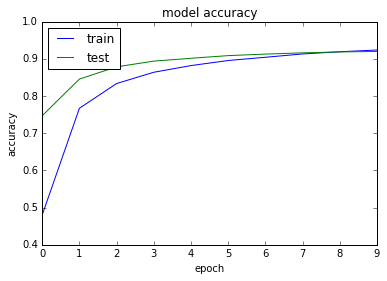

In [39]:
# Accuracy plot for Digit 1
plt.plot(history.history['dense_8_categorical_accuracy'])
plt.plot(history.history['val_dense_8_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

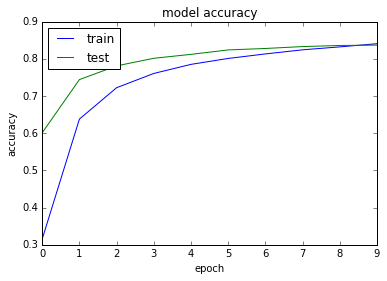

In [40]:
# Accuracy plot for Digit 2
plt.plot(history.history['dense_9_categorical_accuracy'])
plt.plot(history.history['val_dense_9_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

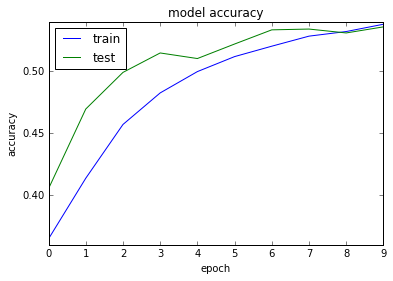

In [41]:
# Accuracy plot for Digit 3
plt.plot(history.history['dense_10_categorical_accuracy'])
plt.plot(history.history['val_dense_10_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

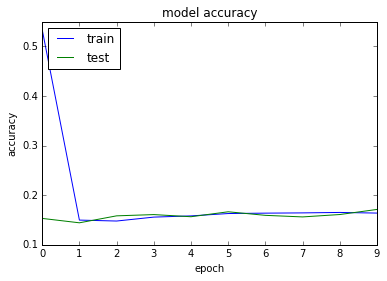

In [42]:
# Accuracy plot for Digit 4
plt.plot(history.history['dense_11_categorical_accuracy'])
plt.plot(history.history['val_dense_11_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

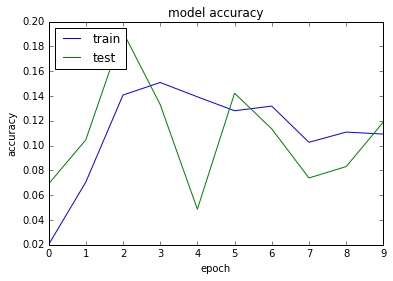

In [43]:
# Accuracy plot for Digit 5
plt.plot(history.history['dense_12_categorical_accuracy'])
plt.plot(history.history['val_dense_12_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

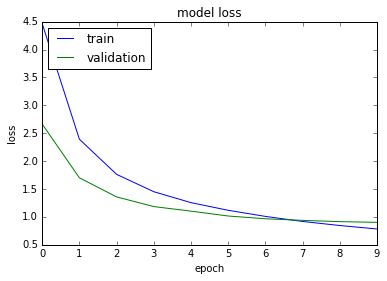

In [44]:
# Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')